In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from batcar import BatCar
from batcar.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import AllSelector, RecentSelector
from batcar.model_updater.wrappers import FrameIO
from batcar.update_trigger import PeriodicTrigger

In [3]:
plt.style.use('makina-notebook')

# Generate Synthetic Data

Text(0.5, 1.0, 'Synthetic Data')

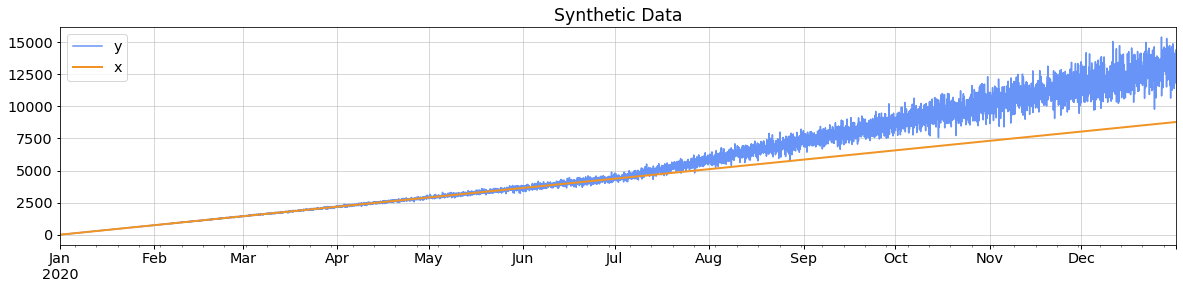

In [4]:
data_times = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

n_samples = len(data_times)
n_phase1 = int(n_samples / 2)
n_phase2 = n_samples - n_phase1

x = pd.DataFrame(np.arange(n_samples).reshape(-1, 1), index=data_times, columns=['x'])

y1_clean = np.arange(n_phase1)
y2_clean = np.arange(n_phase2) * 2 + y1_clean[-1]

y_clean = pd.DataFrame(np.concatenate([y1_clean, y2_clean]), index=data_times, columns=['y'])
y_noise = np.random.randn(*y_clean.shape) * (y_clean * 0.03) * (x.to_numpy()*0.0003)

y = y_clean + y_noise

ax = y.plot.line(figsize=(20,4))
ax = x.plot.line(lw=2, ax=ax)
ax.set_title('Synthetic Data')

# Run BatCar

## Batch-aligned Model Update
- To speed-up of running `BatCar.drive`, one may set `batch_update` to True. 
- This may cause model update at unexpected times.
- So, before using this option, make sure that the model would be updated as intended.

### Driving Time of Unaligned Model Update

In [5]:
%%time

model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=update_interval)

100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |
CPU times: user 8.45 s, sys: 183 ms, total: 8.63 s
Wall time: 8.51 s



Text(0.5, 1.0, "{'mae': 279.68172310552546}")

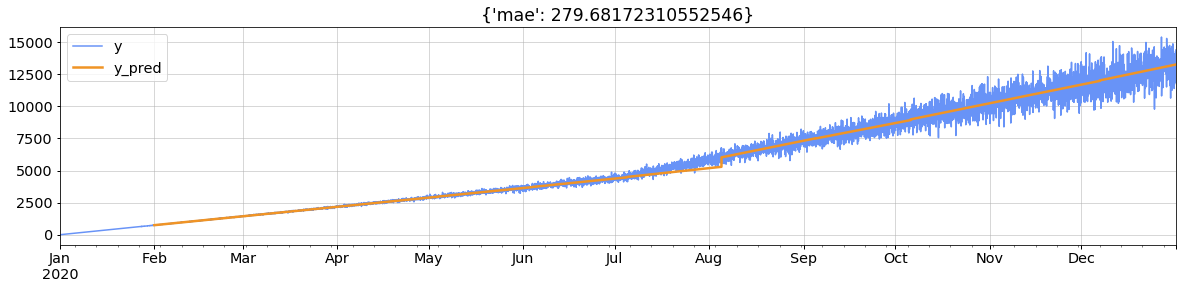

In [6]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

### Driving Time of Alinged Model Update

In [7]:
%%time

model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=update_interval, batch_update=True)

100%|██████████| 12/12 [00:00<00:00, 32.85it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |
CPU times: user 383 ms, sys: 5.98 ms, total: 389 ms
Wall time: 388 ms



Text(0.5, 1.0, "{'mae': 279.68172310552546}")

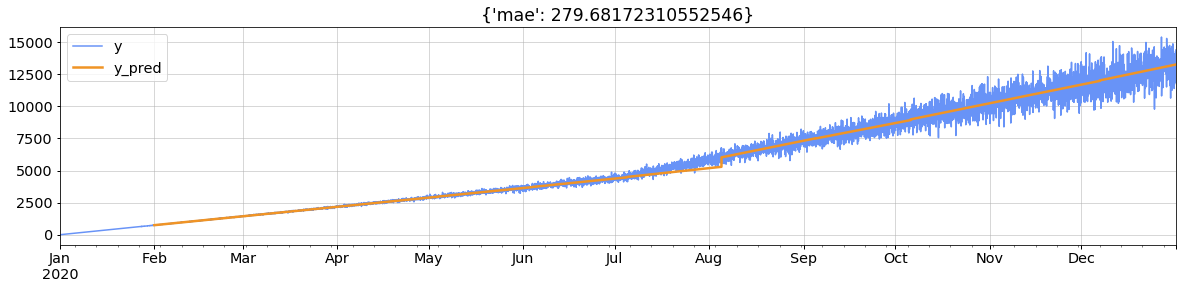

In [8]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

**RESULT: Much faster than the unaligned update with the same update times.**

### Example of Undesirable Behavior of Aligned Model Update
- Below, update interval is set to 31 days, and `batch_size` to 90 days.

In [9]:
%%time

model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size='90 days', batch_update=True)

100%|██████████| 5/5 [00:00<00:00, 37.16it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-03-31 00:00:00 |
|         1 | 2020-06-29 00:00:00 |
|         2 | 2020-09-27 00:00:00 |
|         3 | 2020-12-26 00:00:00 |
CPU times: user 154 ms, sys: 4.2 ms, total: 158 ms
Wall time: 157 ms



Text(0.5, 1.0, "{'mae': 551.4631009075008}")

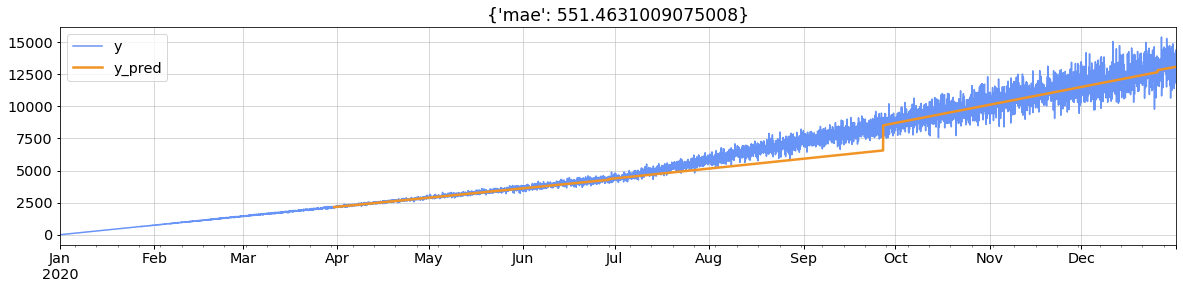

In [10]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

**A large batch size may cause undesirable model update times, and affect its performance.**


### Another Example of Undesirable Behavior of Aligned Model Update
- Below, update interval is set to 31 days, and `batch_size` to 30 days.

In [11]:
%%time

model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size='30 days', batch_update=True)

100%|██████████| 13/13 [00:00<00:00, 65.04it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-03-01 00:00:00 |
|         1 | 2020-04-30 00:00:00 |
|         2 | 2020-06-29 00:00:00 |
|         3 | 2020-08-28 00:00:00 |
|         4 | 2020-10-27 00:00:00 |
|         5 | 2020-12-26 00:00:00 |
CPU times: user 218 ms, sys: 4.27 ms, total: 222 ms
Wall time: 221 ms



Text(0.5, 1.0, "{'mae': 368.254911495257}")

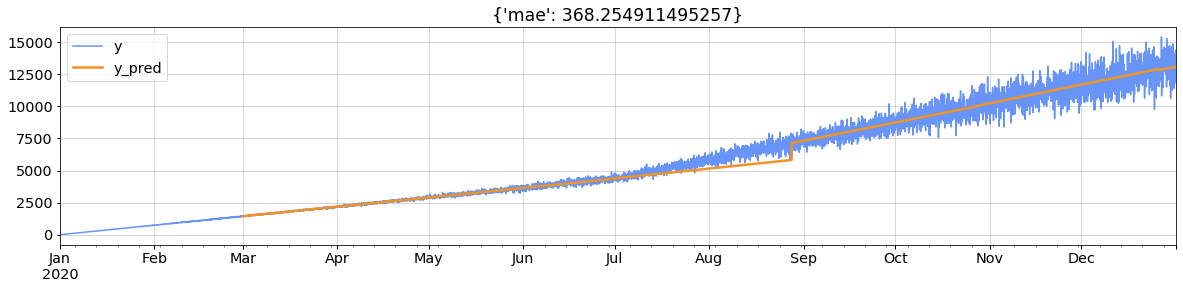

In [12]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

**Even though `update_interval` and `batch_size` are very similar, the result can be very different**